## ML model testing

* logistic / multinomial logistic regression



In [1304]:
import pandas as pd
pd.set_option('display.max_columns',50)
#pd.set_option('display.width',1000)
pd.set_option('display.max_rows', 50)
import numpy as np
from numpy import argmax
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_theme(style='whitegrid')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import norm
from sklearn.utils import resample
from sklearn import linear_model

from collections import Counter

In [1593]:
df = pd.read_csv('/Users/wjdol/Desktop/LighthouseLabs/Flight_delays/data/train_flights_complete_raw200.csv', parse_dates=['fl_date'])

In [1645]:
dftest = pd.read_csv('/Users/wjdol/Desktop/LighthouseLabs/Flight_delays/data/test_flights_complete_raw200.csv', parse_dates=['fl_date'])

In [1449]:
dftest['dest_city'].nunique()

311

In [1644]:
len(dftest)

145212

In [1341]:
df.head()

,Unnamed: 0,mkt_unique_carrier,origin,origin_city,dest,dest_city,crs_elapsed_time,crs_dep_hour,dep_tod,crs_arr_hour,arr_tod,distance,distance_group,fl_date,fl_day,week_num,departures_performed,payload,passengers,freight,sdomt_gallons,tdomt_gallons,sdomt_cost,tdomt_cost,AWND,PRCP,SNOW,SNWD,TAVG,arr_delay,arr_delay_pos,delay_binary
0,0,UA,ORD,Chicago,MHT,Manchester,140.0,11,morning,14,afternoon,843.0,2.0,2018-01-21,Sunday,3,24.0,306500.0,668.0,0.0,6214610.8,6214610.8,12885113.2,12885113.2,17.0,0.0,0.0,0.0,46.0,18.0,18.0,1.0
1,1,WN,AUS,Austin,DAL,Dallas,55.0,22,evening,23,evening,189.0,1.0,2018-01-14,Sunday,2,66.5,2289000.0,6798.0,4205.5,156295770.8,156532592.0,293397830.2,293803944.4,13.0,0.0,0.0,0.0,33.0,-11.0,0.0,0.0
2,2,AA,DFW,Dallas/Fort Worth,IND,Indianapolis,120.0,15,afternoon,18,evening,761.0,2.0,2018-01-04,Thursday,1,119.5,4572500.0,13895.5,4076.5,162609079.0,163140817.6,264949334.8,265791415.6,15.0,0.0,0.0,0.0,38.0,7.0,7.0,1.0
3,4,AS,SEA,Seattle,PDX,Portland,45.0,15,afternoon,16,afternoon,129.0,1.0,2018-01-28,Sunday,4,466.0,8285900.0,23768.0,13757.0,0.0,0.0,0.0,0.0,38.0,15.0,0.0,0.0,83.0,-4.0,0.0,0.0
4,5,DL,LGA,New York,STL,St. Louis,190.0,19,evening,21,evening,888.0,2.0,2018-01-26,Friday,4,71.0,1526642.0,3093.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,-25.0,0.0,0.0


In [1595]:
# drop columns not used

df = df.drop(['Unnamed: 0', 'origin', 'dest', 'dest_city', 'fl_date', 'delay_binary', 'distance', 'sdomt_gallons', 'sdomt_cost', 'arr_delay', 'crs_dep_hour', 'crs_arr_hour', 'SNWD'], axis=1)

In [1596]:
df['week_num'] = df.week_num.astype('object')

In [1597]:
df.loc[df['tdomt_gallons']==0, 'tdomt_gallons'] = np.mean(df['tdomt_gallons'])

In [1598]:
df.loc[df['tdomt_cost']==0,'tdomt_cost'] = np.mean(df['tdomt_cost'])

In [1599]:

df = df.drop(df[df['passengers']==0].index)

In [1600]:
dflreg = df.copy()

In [1573]:
# c1 = list(dflreg['dest_city'])
# c2 = list(dftest['dest_city'])

In [1574]:
# dest_diff = list(set(c1) - set(c2))

149341

In [1577]:
# dflreg = dflreg[~dflreg['dest_city'].isin(dest_diff)]

In [1601]:
# bins for numerical data


dflreg.loc[dflreg['SNOW']>0,'SNOW']=1
# dflreg['SNWD'] = pd.cut(dflreg['SNWD'], bins=[0, 0.1, 60, 150, np.inf], labels=['0','1','2','3'], include_lowest=True)

dflreg.loc[dflreg['PRCP']>0,'PRCP']=1
# dflreg['PRCP'] = pd.cut(dflreg['PRCP'], bins=[0, 0.1, 75, 250, np.inf], labels=['0','1','2','3'], include_lowest=True)

In [1602]:
dflreg['SNOW'] = dflreg.SNOW.astype('int')
dflreg['PRCP'] = dflreg.PRCP.astype('int')

In [1603]:
# make bins for grouping

airlines_list = dict(pd.qcut(dflreg['mkt_unique_carrier'].value_counts(), q=[0, 0.45, 0.9, 1.0], labels=['1','2','3']))

# origin_list = dict(pd.qcut(dflreg['origin'].value_counts(), q=[0, 0.25, 0.5, 1.0], labels=['1','2','3']))

# dest_list = dict(pd.qcut(dflreg['dest'].value_counts(), q=[0, 0.25, 0.5, 1.0], labels=['1','2','3']))


In [1604]:
dflreg['mkt_unique_carrier'].replace(airlines_list, inplace=True)

# dflreg['origin'].replace(origin_list, inplace=True)
# dflreg['dest'].replace(dest_list, inplace=True)

In [719]:
# create list of value counts by columns

# identifier_count = Counter(dict(dflreg['identifier'].value_counts()))
# carrier_count = Counter(dict(dflreg['mkt_unique_carrier'].value_counts()))
# #originc_count = Counter(dict(dflreg['origin_city'].value_counts()))
# origin_count = Counter(dict(dflreg['origin'].value_counts()))
# #destc_count = Counter(dict(dflreg['dest_city'].value_counts()))
# dest_count = Counter(dict(dflreg['dest'].value_counts()))
# wkday_count = Counter(dict(dflreg['fl_day'].value_counts()))
# #type_count = Counter(dict(dflreg['aircraft_type'].value_counts()))
# payl_count = Counter(dict(dflreg['payload'].value_counts()))

In [1317]:
dflreg.head()

,mkt_unique_carrier,origin_city,dest_city,crs_elapsed_time,dep_tod,arr_tod,distance_group,fl_day,week_num,departures_performed,payload,passengers,freight,tdomt_gallons,tdomt_cost,AWND,PRCP,SNOW,TAVG,arr_delay_pos
0,2,Chicago,Manchester,140.0,morning,afternoon,2.0,Sunday,3,24.0,306500.0,668.0,0.0,6.214611e+06,1.288511e+07,17.0,0,0,46.0,18.0
1,2,Austin,Dallas,55.0,evening,evening,1.0,Sunday,2,66.5,2289000.0,6798.0,4205.5,1.565326e+08,2.938039e+08,13.0,0,0,33.0,0.0
2,3,Dallas/Fort Worth,Indianapolis,120.0,afternoon,evening,2.0,Thursday,1,119.5,4572500.0,13895.5,4076.5,1.631408e+08,2.657914e+08,15.0,0,0,38.0,7.0
3,2,Seattle,Portland,45.0,afternoon,afternoon,1.0,Sunday,4,466.0,8285900.0,23768.0,13757.0,9.079810e+07,1.631159e+08,38.0,1,0,83.0,0.0
4,2,New York,St. Louis,190.0,evening,evening,2.0,Friday,4,71.0,1526642.0,3093.0,0.0,9.079810e+07,1.631159e+08,30.0,0,0,0.0,0.0


In [1605]:
# add new features based on fuel consumption, fuel cost, and passengers

dflreg['costPerGallon'] = dflreg['tdomt_cost']/dflreg['tdomt_gallons']
dflreg['costPerPerson'] = dflreg['tdomt_cost']/dflreg['passengers']
dflreg['gallonPerPerson'] = dflreg['tdomt_gallons']/dflreg['passengers']


In [645]:
# determine quartile splits

# top_carriers = top_categories(carrier_count, 0.90)
# top_dest = top_categories(dest_count, 0.5)
# top_origin = top_categories(origin_count, 0.5)
# top_identifier = top_categories(identifier_count, 0.05)

In [990]:
dflreg.head()

,mkt_unique_carrier,origin,dest,fl_day,week_num,dep_time_of_day,arr_time_of_day,departures_performed,payload,passengers,distance_group,delay_binary,tdomt_gallons,tdomt_cost,AWND,PRCP,SNOW,SNWD,TAVG,costPerGallon,costPerPerson,gallonPerPerson
0,2,3,3,6,2,evening,evening,3.0,118728.0,312.5,2.0,0.0,149458650.6,288453038.8,31.0,1,0.0,0,234.0,1.929986,923049.724160,478267.681920
1,3,3,3,0,3,morning,morning,111.5,4801900.0,14754.5,3.0,1.0,163140817.6,265791415.6,30.0,0,3.0,3,-2.0,1.629215,18014.261114,11057.021085
2,3,3,3,3,2,afternoon,afternoon,23.0,349600.0,1603.0,1.0,0.0,6214610.8,12885113.2,20.0,0,0.0,0,-78.0,2.073358,8038.124267,3876.862633
3,2,1,3,4,2,afternoon,evening,3.0,104033.0,429.0,5.0,0.0,115971276.2,193359267.6,29.0,0,0.0,0,-52.0,1.667303,450720.903497,270329.315152
4,2,3,2,3,1,evening,overnight,29.0,565920.0,1876.0,1.0,0.0,6214610.8,12885113.2,33.0,0,0.0,0,-23.0,2.073358,6868.397228,3312.692324


In [1319]:
dflreg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149470 entries, 0 to 149473
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   mkt_unique_carrier    149470 non-null  object 
 1   origin_city           149470 non-null  object 
 2   dest_city             149470 non-null  object 
 3   crs_elapsed_time      149470 non-null  float64
 4   dep_tod               149470 non-null  object 
 5   arr_tod               149470 non-null  object 
 6   distance_group        149470 non-null  float64
 7   fl_day                149470 non-null  object 
 8   week_num              149470 non-null  object 
 9   departures_performed  149470 non-null  float64
 10  payload               149470 non-null  float64
 11  passengers            149470 non-null  float64
 12  freight               149470 non-null  float64
 13  tdomt_gallons         149470 non-null  float64
 14  tdomt_cost            149470 non-null  float64
 15  

In [1606]:
dflreg = pd.get_dummies(dflreg, columns=['dep_tod','arr_tod', 'origin_city', 'week_num', 'fl_day'], drop_first=True)

C:\Users\wjdol\Desktop\LighthouseLabs\env\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [1607]:
# split features and target

y = dflreg['arr_delay_pos']
X = dflreg.drop('arr_delay_pos', axis=1)

In [1608]:
# train / test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [1609]:
num_X_train = X_train.select_dtypes(include=['float64'])
num_X_test = X_test.select_dtypes(include=['float64'])

In [1362]:
num_X_train

,crs_elapsed_time,distance_group,departures_performed,payload,passengers,freight,tdomt_gallons,tdomt_cost,AWND,TAVG,costPerGallon,costPerPerson,gallonPerPerson
146377,107.0,2.0,67.0,2425400.0,5809.0,390.0,163140817.6,265791415.6,18.0,136.0,1.629215,45755.106834,28084.148322
70889,115.0,2.0,18.5,759500.0,2260.0,3478.5,156532592.0,293803944.4,50.0,-191.0,1.876951,130001.745310,69262.208850
55544,89.0,1.0,24.5,885550.0,2339.5,2227.0,163140817.6,265791415.6,40.0,113.0,1.629215,113610.350759,69733.198376
114709,165.0,3.0,23.0,1470900.0,4156.0,6049.0,163140817.6,265791415.6,24.0,215.0,1.629215,63953.661116,39254.287199
37061,157.0,2.0,6.0,295005.0,755.0,8781.0,149458650.6,288453038.8,92.0,52.0,1.929986,382057.005033,197958.477616
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122859,85.0,1.0,49.0,1935500.0,5611.0,856.0,163140817.6,265791415.6,34.0,127.0,1.629215,47369.705151,29075.176903
108180,165.0,2.0,71.0,710000.0,2564.0,0.0,54337.0,144824.4,67.0,103.0,2.665300,56.483775,21.192278
80756,122.0,2.0,31.0,1086000.0,4362.0,0.0,24685799.8,45916819.2,34.0,33.0,1.860050,10526.551857,5659.284686
76560,88.0,1.0,231.0,4723372.5,7878.5,0.0,5327632.2,7937670.4,25.0,42.0,1.489906,1007.510364,676.224180


In [1198]:
# dflreg.isnull().sum()

In [1610]:
cat_X_train = X_train.select_dtypes(exclude=['float64'])
cat_X_test = X_test.select_dtypes(exclude=['float64'])

In [1611]:
scaler = StandardScaler()

scaler.fit(num_X_train)

scaled_X_train = scaler.transform(num_X_train)
scaled_X_test = scaler.transform(num_X_test)


In [1612]:
cat_X_train_f = cat_X_train.to_numpy()
cat_X_test_f = cat_X_test.to_numpy()

In [1613]:
X_train_f = np.hstack((cat_X_train_f, scaled_X_train))
X_test_f = np.hstack((cat_X_test_f, scaled_X_test))

In [1614]:
# create ensemble model

ens_0 = RandomForestRegressor(max_depth=10, n_jobs=-1)

ens_0.fit(X_train_f, y_train)

RandomForestRegressor(max_depth=10, n_jobs=-1)

In [1615]:
ens_0.score(X_test_f, y_test)

0.045164454602508064

In [1332]:
ens_0.decision_path(X_test_f)

(<29894x64064 sparse matrix of type '<class 'numpy.int64'>'
 	with 32874295 stored elements in Compressed Sparse Row format>,
 array([    0,   681,  1310,  1885,  2488,  3161,  3802,  4399,  5032,
         5675,  6316,  6901,  7328,  8009,  8600,  9373,  9926, 10569,
        11216, 11997, 12664, 13217, 13714, 14355, 15020, 15643, 16366,
        16933, 17436, 18195, 18838, 19445, 20002, 20585, 21378, 22029,
        22636, 23141, 23588, 24113, 24774, 25455, 26110, 26721, 27398,
        28197, 28992, 29479, 30182, 30685, 31406, 31961, 32716, 33363,
        34004, 34639, 35314, 35959, 36494, 36989, 37536, 38115, 38776,
        39467, 40236, 40913, 41616, 42209, 42838, 43541, 44278, 44889,
        45654, 46411, 46808, 47479, 48244, 48829, 49624, 50179, 50904,
        51617, 52230, 52887, 53560, 54139, 54828, 55357, 56040, 56819,
        57482, 58041, 58500, 59197, 59796, 60501, 61150, 61957, 62634,
        63401, 64064], dtype=int32))

In [1214]:
coeffs = np.hstack((ens_0.intercept_, ens_0.coef_))
coeffs_tbl = pd.DataFrame(data={'variable': ['intercept'] + list(X.columns) , 'coefficient': coeffs})

<BarContainer object of 25 artists>

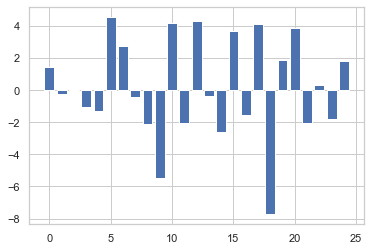

In [1215]:
plt.bar([x for x in range(len(ens_0.coef_))], ens_0.coef_)

In [1216]:
coeffs_tbl.sort_values(by='coefficient', ascending=False)

,variable,coefficient
0,intercept,4.894405
6,departures_performed,4.577657
13,PRCP,4.331385
11,tdomt_cost,4.218508
18,costPerPerson,4.108742
21,dep_time_of_day_morning,3.878090
16,TAVG,3.716991
7,payload,2.752106
20,dep_time_of_day_evening,1.911286
25,arr_time_of_day_overnight,1.796018


In [1470]:
# params = {}

ens_1 = RandomForestRegressor()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 3000, num = 100)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8]

# Method of selecting samples for training each tree
bootstrap = [True]



params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

reg_cv = RandomizedSearchCV(ens_1, param_distributions=params, n_iter=2, cv=2, n_jobs=-1, scoring='r2', verbose=2)


In [1471]:
reg_cv.fit(X_train_f, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=2, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 4, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1000, 1020, 1040, 1060,
                                                         1080, 1101, 1121, 1141,
                                                         1161, 1181, 1202, 1222,
                                                         1242, 1262, 1282, 1303,
                                                         1323, 1343, 1363, 1383,
                                                         1404, 1424, 1444, 1464,
      

In [1472]:
reg_cv.best_params_

{'n_estimators': 2454,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 65,
 'bootstrap': True}

In [1473]:
reg_cv.best_estimator_

RandomForestRegressor(max_depth=65, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=2454)

In [1474]:
reg_cv.best_score_

0.0653682618521172

In [1299]:
# Pkl_Filename = 'Pickle_RFReg_model.pkl'

# with open(Pkl_Filename, 'wb') as file:
#     pickle.dump(reg_cv, file)

In [1292]:
reg_cv.cv_results_

{'mean_fit_time': array([110.70482477, 198.10736473, 225.93396187, 179.69483511,
        137.2455461 ]),
 'std_fit_time': array([ 2.72673551,  1.28835478,  3.87498468, 14.6053607 ,  6.93639389]),
 'mean_score_time': array([ 5.76797915,  9.28265921, 10.22500062,  6.79633387,  5.1833361 ]),
 'std_score_time': array([0.50560136, 0.64799735, 0.78150705, 0.87647011, 0.19368775]),
 'param_n_estimators': masked_array(data=[1571, 1979, 2673, 1816, 1734],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[5, 5, 10, 2, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[8, 2, 4, 2, 2],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt'],
              m

<BarContainer object of 25 artists>

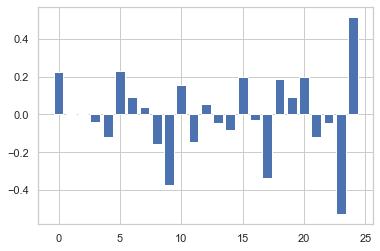

In [1172]:
# display feature importance

# model ens_0:

importance_0 = ens_0.coef_[0]
   
    
coefficients = np.hstack((ens_0.intercept_, ens_0.coef_[0]))
coeffs_df = pd.DataFrame(data={'variable': ['intercept'] + list(X), 'coefficient': coefficients})
    
plt.bar([x for x in range(len(importance_0))], importance_0)



In [1173]:
coeffs_df.sort_values(by='coefficient', ascending=False)

,variable,coefficient
25,arr_time_of_day_overnight,0.515902
6,departures_performed,0.226833
1,mkt_unique_carrier,0.223454
16,TAVG,0.197201
21,dep_time_of_day_morning,0.195865
19,gallonPerPerson,0.184297
11,tdomt_cost,0.152776
20,dep_time_of_day_evening,0.094008
7,payload,0.092794
13,PRCP,0.053579


### Test table transform

In [1616]:
dftest.head()

,Unnamed: 0,mkt_unique_carrier,origin,origin_city,dest,dest_city,crs_elapsed_time,crs_dep_hour,dep_tod,crs_arr_hour,arr_tod,distance,distance_group,fl_date,fl_day,week_num,departures_performed,payload,passengers,freight,sdomt_gallons,tdomt_gallons,sdomt_cost,tdomt_cost,AWND,PRCP,SNOW,SNWD,TAVG
0,1,DL,DTW,Detroit,OMA,Omaha,147,8,morning,10,morning,651,2.0,2020-01-23,Thursday,4,15.0,192000.0,478.0,0.0,6214610.8,6214610.8,12885113.2,12885113.2,18.0,0.0,0.0,100.0,-7.0
1,3,WN,OAK,Oakland,SAN,San Diego,90,11,morning,13,afternoon,446,1.0,2020-01-30,Thursday,5,71.5,2530500.0,7156.5,3849.5,156295770.8,156532592.0,293397830.2,293803944.4,18.0,0.0,0.0,0.0,128.0
2,4,UA,EWR,Newark,BUF,Buffalo,88,22,evening,23,evening,282,1.0,2020-01-29,Wednesday,5,1.0,50408.5,152.0,106.0,115001515.0,115971276.2,191543386.6,193359267.6,58.0,0.0,0.0,0.0,32.0
3,6,AA,PHX,Phoenix,ORD,Chicago,210,9,morning,14,afternoon,1440,3.0,2020-01-06,Monday,2,31.0,1468700.0,3841.5,3578.5,162609079.0,163140817.6,264949334.8,265791415.6,16.0,0.0,0.0,0.0,127.0
4,7,AA,PHL,Philadelphia,CLT,Charlotte,114,11,morning,13,afternoon,449,1.0,2020-01-26,Sunday,4,29.0,1170300.0,2866.0,2493.0,162609079.0,163140817.6,264949334.8,265791415.6,41.0,0.0,0.0,0.0,61.0


In [1646]:
dftest_final = dftest.drop(dftest[dftest['passengers']==0].index)

In [1647]:
len(dftest_final)

145157

In [1617]:
# drop columns not used

dftest1 = dftest.drop(['Unnamed: 0', 'origin', 'dest', 'dest_city', 'fl_date', 'distance', 'sdomt_gallons', 'sdomt_cost', 'crs_dep_hour', 'crs_arr_hour', 'SNWD'], axis=1)

In [ ]:
# dftest['week_num'] = dftest.week_num.astype('object')

In [1618]:
dftest1.loc[dftest1['tdomt_gallons']==0, 'tdomt_gallons'] = np.mean(dftest1['tdomt_gallons'])

In [1619]:
dftest1.loc[dftest1['tdomt_cost']==0,'tdomt_cost'] = np.mean(dftest1['tdomt_cost'])

In [1620]:

dftest1 = dftest1.drop(dftest1[dftest1['passengers']==0].index)

In [1621]:
# bins for numerical data


dftest1.loc[dftest1['SNOW']>0,'SNOW']=1
# dflreg['SNWD'] = pd.cut(dflreg['SNWD'], bins=[0, 0.1, 60, 150, np.inf], labels=['0','1','2','3'], include_lowest=True)

dftest1.loc[dftest1['PRCP']>0,'PRCP']=1
# dflreg['PRCP'] = pd.cut(dflreg['PRCP'], bins=[0, 0.1, 75, 250, np.inf], labels=['0','1','2','3'], include_lowest=True)

In [1622]:
dftest1['SNOW'] = dftest1.SNOW.astype('int')
dftest1['PRCP'] = dftest1.PRCP.astype('int')

In [1623]:
# make bins for grouping

test_airlines_list = dict(pd.qcut(dftest1['mkt_unique_carrier'].value_counts(), q=[0, 0.45, 0.9, 1.0], labels=['1','2','3']))

# origin_list = dict(pd.qcut(dflreg['origin'].value_counts(), q=[0, 0.25, 0.5, 1.0], labels=['1','2','3']))

# dest_list = dict(pd.qcut(dflreg['dest'].value_counts(), q=[0, 0.25, 0.5, 1.0], labels=['1','2','3']))

In [1624]:
dftest1['mkt_unique_carrier'].replace(test_airlines_list, inplace=True)

# dflreg['origin'].replace(origin_list, inplace=True)
# dflreg['dest'].replace(dest_list, inplace=True)

In [1625]:
# add new features based on fuel consumption, fuel cost, and passengers

dftest1['costPerGallon'] = dftest1['tdomt_cost']/dftest1['tdomt_gallons']
dftest1['costPerPerson'] = dftest1['tdomt_cost']/dftest1['passengers']
dftest1['gallonPerPerson'] = dftest1['tdomt_gallons']/dftest1['passengers']

In [1626]:
dftest1['crs_elapsed_time'] = dftest1.crs_elapsed_time.astype('float')


In [1627]:
dftest1 = pd.get_dummies(dftest1, columns=['dep_tod','arr_tod', 'origin_city', 'week_num', 'fl_day'], drop_first=True)

In [1387]:
num_dftest.head()




,distance_group,departures_performed,payload,passengers,freight,tdomt_gallons,tdomt_cost,AWND,TAVG,costPerGallon,costPerPerson,gallonPerPerson
0,2.0,13.5,484700.0,1321.5,333.0,156532592.0,2.938039e+08,33.0,108.0,1.876951,222326.102459,118450.693908
1,4.0,3.5,129500.0,472.5,545.0,156532592.0,2.938039e+08,33.0,108.0,1.876951,621807.289735,331285.908995
2,2.0,31.0,1345400.0,4165.5,9088.5,156532592.0,2.938039e+08,33.0,108.0,1.876951,70532.695811,37578.344016
3,2.0,31.0,1345400.0,4165.5,9088.5,156532592.0,1.635626e+08,33.0,108.0,1.044911,39266.018924,37578.344016
4,2.0,31.0,1345400.0,4165.5,9088.5,156532592.0,1.635626e+08,33.0,108.0,1.044911,39266.018924,37578.344016


In [1443]:
cat_dftest.head()

,mkt_unique_carrier,PRCP,SNOW,dep_tod_evening,dep_tod_morning,dep_tod_overnight,arr_tod_evening,arr_tod_morning,arr_tod_overnight,origin_city_Austin,origin_city_Baltimore,origin_city_Boston,origin_city_Charlotte,origin_city_Chicago,origin_city_Cincinnati,origin_city_Cleveland,origin_city_Columbus,origin_city_Dallas,origin_city_Dallas/Fort Worth,origin_city_Denver,origin_city_Detroit,origin_city_Fort Lauderdale,origin_city_Fort Myers,origin_city_Honolulu,origin_city_Houston,...,dest_city_Valparaiso,dest_city_Vernal,dest_city_Waco,dest_city_Walla Walla,dest_city_Washington,dest_city_Waterloo,dest_city_Wenatchee,dest_city_West Palm Beach/Palm Beach,dest_city_White Plains,dest_city_Wichita,dest_city_Wichita Falls,dest_city_Wilmington,dest_city_Worcester,dest_city_Yakima,dest_city_Yuma,week_num_2,week_num_3,week_num_4,week_num_5,fl_day_Monday,fl_day_Saturday,fl_day_Sunday,fl_day_Thursday,fl_day_Tuesday,fl_day_Wednesday
0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [1399]:
cat_X_test.head()

,mkt_unique_carrier,PRCP,SNOW,dep_tod_evening,dep_tod_morning,dep_tod_overnight,arr_tod_evening,arr_tod_morning,arr_tod_overnight,origin_city_Austin,origin_city_Baltimore,origin_city_Boston,origin_city_Charlotte,origin_city_Chicago,origin_city_Cincinnati,origin_city_Cleveland,origin_city_Columbus,origin_city_Dallas,origin_city_Dallas/Fort Worth,origin_city_Denver,origin_city_Detroit,origin_city_Fort Lauderdale,origin_city_Fort Myers,origin_city_Honolulu,origin_city_Houston,...,dest_city_Vernal,dest_city_Waco,dest_city_Walla Walla,dest_city_Washington,dest_city_Waterloo,dest_city_Watertown,dest_city_Wenatchee,dest_city_West Palm Beach/Palm Beach,dest_city_White Plains,dest_city_Wichita,dest_city_Wichita Falls,dest_city_Wilmington,dest_city_Worcester,dest_city_Yakima,dest_city_Yuma,week_num_2,week_num_3,week_num_4,week_num_5,fl_day_Monday,fl_day_Saturday,fl_day_Sunday,fl_day_Thursday,fl_day_Tuesday,fl_day_Wednesday
142728,2,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
60967,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
60566,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
77968,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
23809,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [1628]:
num_dftest = dftest1.select_dtypes(include=['float64'])

In [1629]:
cat_dftest = dftest1.select_dtypes(exclude=['float64'])

In [1630]:
scaled_dftest = scaler.transform(num_dftest)

In [1631]:
cat_dftest_f = cat_dftest.to_numpy()

In [1632]:
dftest_f = np.hstack((cat_dftest_f, scaled_dftest))

In [1639]:
model_prediction = pd.DataFrame(ens_0.predict(dftest_f))

In [1640]:
true_df = pd.DataFrame(dftest_f)

In [1641]:
true_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,-0.009556,-0.126046,-0.500787,-0.620968,-0.660625,-0.168636,-1.646442,-1.617847,-1.092152,-0.664138,1.31501,-0.342458,-0.359904
1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,-0.755173,-0.940709,0.436489,0.584731,0.545445,-0.042572,0.880509,0.990217,-1.092152,0.832652,0.285165,-0.289959,-0.2987
2,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,1,-0.781335,-0.940709,-0.733032,-0.693971,-0.719497,-0.165165,0.198645,0.057684,0.964185,-0.231732,-0.814103,4.294396,4.814087
3,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0.814546,0.688617,-0.235364,0.037281,-0.053211,-0.051447,0.991598,0.730147,-1.194969,0.821565,-1.013816,-0.185184,-0.156615
4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,0,-0.441229,-0.940709,-0.268542,-0.11657,-0.229376,-0.086995,0.991598,0.730147,0.090242,0.089801,-1.013816,-0.097485,-0.056892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145152,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0.343631,-0.126046,0.851213,0.269449,0.297766,-0.168636,-0.220472,-0.216614,1.838128,0.599818,-0.121613,-0.337391,-0.341029
145153,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0.657574,0.688617,-0.235364,0.037281,-0.053211,-0.051447,0.991598,0.730147,-1.246377,0.67743,-1.013816,-0.185184,-0.156615
145154,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,-1.003712,-0.940709,-0.733032,-0.699131,-0.718233,-0.168636,0.991598,0.730147,-0.783702,1.46463,-1.013816,5.782276,6.629021
145155,2,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,-1.12144,-0.940709,0.245716,-0.314968,-0.369514,-0.168636,-1.646442,-1.617847,0.604326,0.289373,1.31501,-0.419883,-0.429085


In [1642]:
model_prediction

,0
0,8.808797
1,4.450689
2,8.167933
3,6.834702
4,6.550334
...,...
145152,25.918173
145153,9.440277
145154,23.261238
145155,24.759463


In [1648]:
dftest_final['prediction'] = model_prediction

In [1652]:
dftest_final.head()

,Unnamed: 0,mkt_unique_carrier,origin,origin_city,dest,dest_city,crs_elapsed_time,crs_dep_hour,dep_tod,crs_arr_hour,arr_tod,distance,distance_group,fl_date,fl_day,week_num,departures_performed,payload,passengers,freight,sdomt_gallons,tdomt_gallons,sdomt_cost,tdomt_cost,AWND,PRCP,SNOW,SNWD,TAVG,prediction
0,1,DL,DTW,Detroit,OMA,Omaha,147,8,morning,10,morning,651,2.0,2020-01-23,Thursday,4,15.0,192000.0,478.0,0.0,6214610.8,6214610.8,12885113.2,12885113.2,18.0,0.0,0.0,100.0,-7.0,8.808797
1,3,WN,OAK,Oakland,SAN,San Diego,90,11,morning,13,afternoon,446,1.0,2020-01-30,Thursday,5,71.5,2530500.0,7156.5,3849.5,156295770.8,156532592.0,293397830.2,293803944.4,18.0,0.0,0.0,0.0,128.0,4.450689
2,4,UA,EWR,Newark,BUF,Buffalo,88,22,evening,23,evening,282,1.0,2020-01-29,Wednesday,5,1.0,50408.5,152.0,106.0,115001515.0,115971276.2,191543386.6,193359267.6,58.0,0.0,0.0,0.0,32.0,8.167933
3,6,AA,PHX,Phoenix,ORD,Chicago,210,9,morning,14,afternoon,1440,3.0,2020-01-06,Monday,2,31.0,1468700.0,3841.5,3578.5,162609079.0,163140817.6,264949334.8,265791415.6,16.0,0.0,0.0,0.0,127.0,6.834702
4,7,AA,PHL,Philadelphia,CLT,Charlotte,114,11,morning,13,afternoon,449,1.0,2020-01-26,Sunday,4,29.0,1170300.0,2866.0,2493.0,162609079.0,163140817.6,264949334.8,265791415.6,41.0,0.0,0.0,0.0,61.0,6.550334


In [1651]:
work = dftest_final.copy()

In [1659]:
work['month'] = work['fl_date'].dt.month

In [1663]:
work = work[(work['month']==1) & (work['week_num']==1)]

In [1664]:
work.head()

,Unnamed: 0,mkt_unique_carrier,origin,origin_city,dest,dest_city,crs_elapsed_time,crs_dep_hour,dep_tod,crs_arr_hour,arr_tod,distance,distance_group,fl_date,fl_day,week_num,departures_performed,payload,passengers,freight,sdomt_gallons,tdomt_gallons,sdomt_cost,tdomt_cost,AWND,PRCP,SNOW,SNWD,TAVG,prediction,month
6,10,UA,DEN,Denver,SMF,Sacramento,161,19,evening,21,evening,909,2.0,2020-01-02,Thursday,1,18.0,697002.0,2395.0,353.0,1.150015e+08,1.159713e+08,191543386.6,193359267.6,18.0,0.0,0.0,0.0,23.0,8.857549,1
15,20,WN,SFO,San Francisco,LAS,Las Vegas,90,6,morning,8,morning,414,1.0,2020-01-03,Friday,1,46.0,1605800.0,4663.0,3169.0,1.562958e+08,1.565326e+08,293397830.2,293803944.4,16.0,0.0,0.0,0.0,111.0,3.492551,1
21,26,AS,SFO,San Francisco,SEA,Seattle,135,19,evening,22,evening,679,2.0,2020-01-02,Thursday,1,41.5,1614542.5,4840.0,10199.0,4.415073e+07,4.421676e+07,83009420.0,83115270.4,26.0,0.0,0.0,0.0,120.0,8.961354,1
46,61,AS,SEA,Seattle,DFW,Dallas/Fort Worth,235,6,morning,12,afternoon,1660,4.0,2020-01-02,Thursday,1,10.0,410300.0,1362.0,9341.0,4.415073e+07,4.421676e+07,83009420.0,83115270.4,41.0,53.0,0.0,0.0,73.0,7.484208,1
50,65,UA,IAD,Washington,BUF,Buffalo,82,8,morning,10,morning,283,1.0,2020-01-02,Thursday,1,11.5,146880.0,422.5,0.0,4.164202e+06,4.164202e+06,7004583.0,7004583.0,23.0,0.0,0.0,0.0,16.0,7.978788,1


In [1665]:
work = work.drop(['Unnamed: 0', 'origin_city', 'dest_city', 'distance', 'sdomt_gallons', 'sdomt_cost', 'crs_dep_hour', 'crs_arr_hour', 'SNWD', 'dep_tod', 'crs_elapsed_time', 'crs_dep_hour', 'crs_arr_hour', 'distance_group', 'AWND'], axis=1)

In [1667]:
work = work.drop(['arr_tod', 'fl_day', 'week_num', 'departures_performed', 'payload', 'passengers', 'freight', 'tdomt_gallons', 'tdomt_cost', 'PRCP', 'SNOW', 'TAVG', 'month'], axis=1)

In [1668]:
work.head()

,mkt_unique_carrier,origin,dest,fl_date,prediction
6,UA,DEN,SMF,2020-01-02,8.857549
15,WN,SFO,LAS,2020-01-03,3.492551
21,AS,SFO,SEA,2020-01-02,8.961354
46,AS,SEA,DFW,2020-01-02,7.484208
50,UA,IAD,BUF,2020-01-02,7.978788


In [1669]:
work.to_csv('prediction_submission.csv')